# CENG 483 THE 2

**Name:** Derya TINMAZ

**Student ID:** 2380947


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage import convolve

In [2]:
# reading all images
image_names = ['chessboard','chessboard-rotated','lab','lab-rotated','tree','tree-rotated']
images=[]
for i in image_names:
    images.append(cv2.imread(i+'.png'))

libpng warning: iCCP: known incorrect sRGB profile


In [3]:
def non_maximum_suppression(res):
    h, w = res.shape
    for y in range(5, h - 5):
        for x in range(5, w - 5):
            local_window = res[y - 5:y + 6, x - 5:x + 6]
            local_max = np.max(local_window)
            if res[y, x] == local_max:
                res[y - 5:y + 6, x - 5:x + 6] = 0
                res[y, x] = local_max
            else:
                res[y, x] = 0

    return res


In [4]:
#top-10 corners
def max_10_indices(feature_map):
    max_indices = []
    for _ in range(10):
        max_val = 0
        max_index = (0, 0)
        for y in range(2, len(feature_map) - 2):
            for x in range(2, len(feature_map[0]) - 2):
                if feature_map[y][x] > max_val and (y, x) not in max_indices:
                    max_val = feature_map[y][x]
                    max_index = (y, x)
        max_indices.append(max_index)
    return max_indices

In [5]:
def display_max_circles(image, max_indices):
    img_copy = image.copy()
    for i, (y, x) in enumerate(max_indices):
        cv2.circle(img_copy, (x, y), 1, (51,255,255), 2)
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.show()

## Naive Formula + Uniform Weighting (without Non-Maximum Suppression)

In [6]:
def naive_uniform_without_suppression(image):

    # converting the image into gray scale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    
    # creating empty array for differences
    feature_map = np.zeros(gray_image.shape)

    for y in range(2, len(gray_image) - 2):
        for x in range(2, len(gray_image[0]) - 2):
            
            # shifting the window into 8 directions and summing the squared distances
            total_difference = 0
            window = gray_image[y - 1:y + 2, x - 1:x + 2]
            for m in range(-1, 2):
                for n in range(-1, 2):
                    shifted_window = gray_image[y + m - 1:y + m + 2, x + n - 1: x + n + 2]
                    total_difference += np.sum(np.square(window - shifted_window))
            
            # putting the results into the array
            feature_map[y][x] = total_difference

    # top-10 corners
    max_indices = max_10_indices(feature_map)
    
    return max_indices

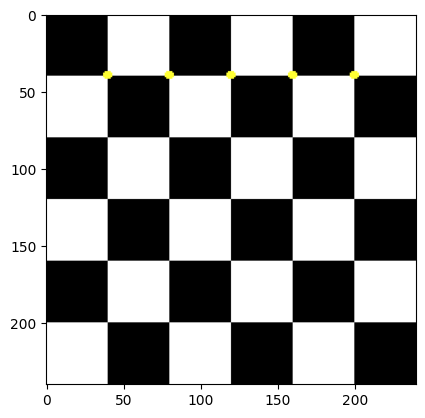

time taken to process the chessboard image is 8.378


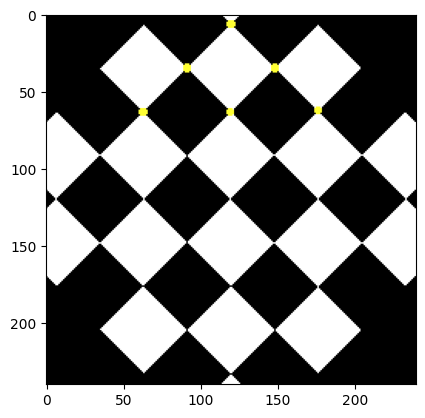

time taken to process the chessboard-rotated image is 7.803


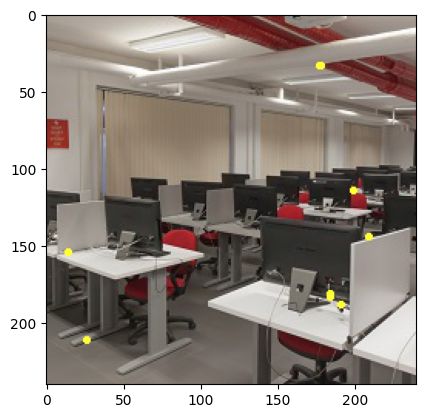

time taken to process the lab image is 7.995


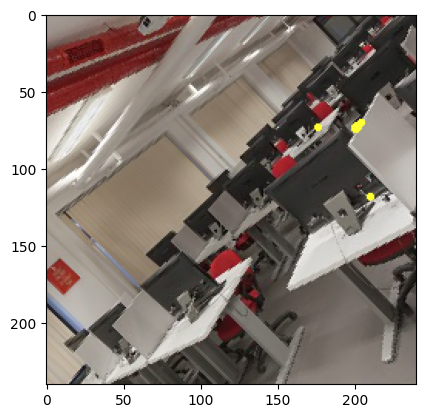

time taken to process the lab-rotated image is 7.384


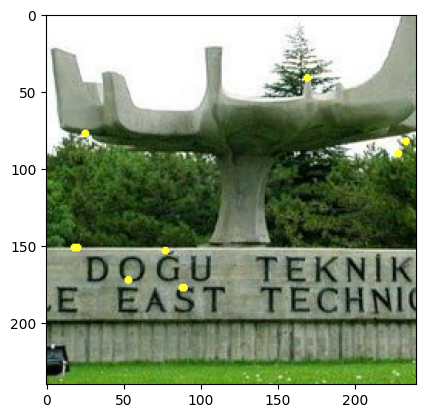

time taken to process the tree image is 7.045


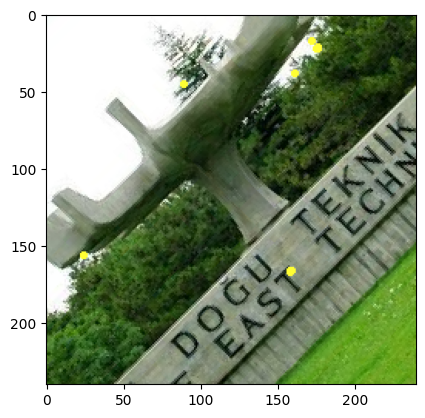

time taken to process the tree-rotated image is 7.233
the average time to process one image: 7.639737 


In [7]:
total_time = 0
for i in range(6):
    start = time.time()
    max_indices = naive_uniform_without_suppression(images[i])
    end = time.time()
    display_max_circles(images[i], max_indices)
    time_passed= (end-start)
    total_time += time_passed
    print(f"time taken to process the {image_names[i]} image is {round(time_passed, 3)}")
print("the average time to process one image: %f " % (total_time/6))



The Naive Formula with uniform weighting simplifies the implementation of the Harris Corner Detector. However, calculating the squared sum of differences for each pixel is computationally expensive, and the method is sensitivite to noise, lack of rotational and scale invariance. Moreover, without using the non-maximum suppression increases potential for redundant detections. For example, in the chess board image, some of the detected corners are overlapped. As we can see from the results, the average time to process the image is high and detected top-10 corners between the original and the rotated version of the images are quite different.

## Naive Formula + Uniform Weighting

In [8]:
def naive_uniform(image):

    #converting the image into gray scale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    #creating empty array for differences
    feature_map = np.zeros(gray_image.shape)

    for y in range(2, len(gray_image) - 2):
        for x in range(2, len(gray_image[0]) - 2):
            #shifting the window into 8 directions and summing the squared distances
            total_difference = 0
            window = gray_image[y - 1:y + 2, x - 1:x + 2]
            for m in range(-1, 2):
                for n in range(-1, 2):
                    shifted_window = gray_image[y + m - 1:y + m + 2, x + n - 1: x + n + 2]
                    total_difference += np.sum(np.square(window - shifted_window))
            #putting the results into the array
            feature_map[y][x] = total_difference
    
    suppressed_distances = non_maximum_suppression(feature_map)

    #calculating the max 10 values
    max_indices = max_10_indices(suppressed_distances)

    return max_indices



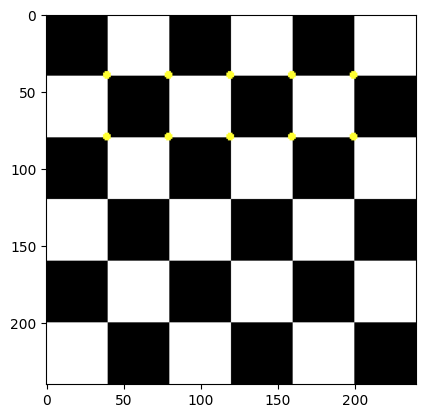

time taken to process the chessboard image is 7.658


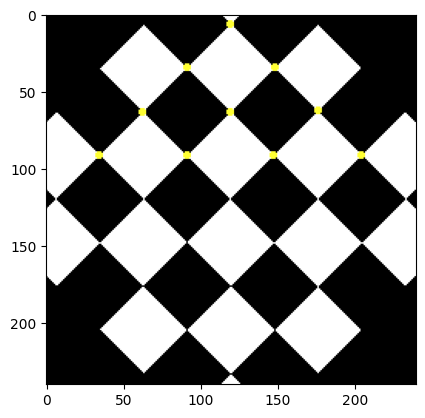

time taken to process the chessboard-rotated image is 8.013


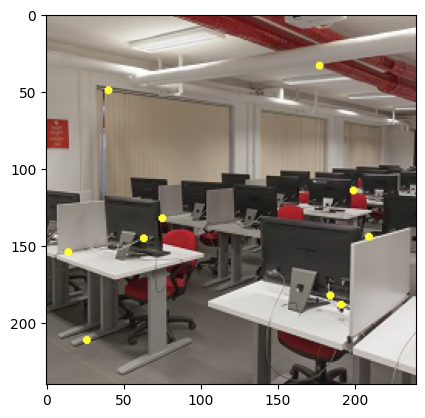

time taken to process the lab image is 8.495


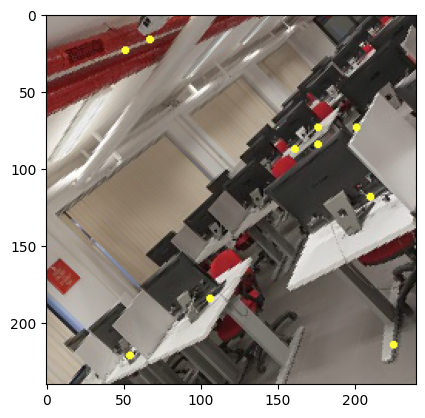

time taken to process the lab-rotated image is 8.017


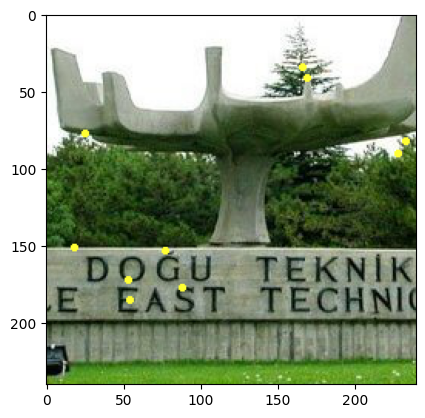

time taken to process the tree image is 7.996


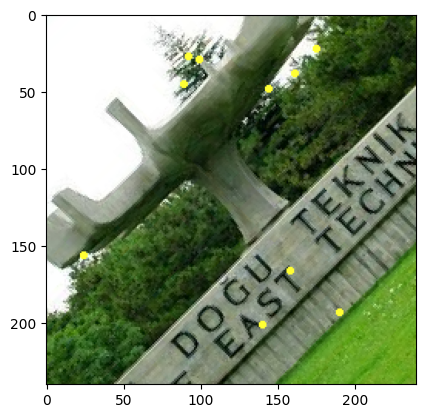

time taken to process the tree-rotated image is 8.652
the average time to process one image: 8.138348 


In [9]:
total_time = 0
for i in range(6):
    start = time.time()
    max_indices = naive_uniform(images[i])
    end = time.time()
    display_max_circles(images[i], max_indices)
    time_passed= (end-start)
    total_time += time_passed
    print(f"time taken to process the {image_names[i]} image is {round(time_passed, 3)}")
print("the average time to process one image: %f " % (total_time/6))

The difference between the previous version and this version is applying the non-maximum suppression. Simple application is still an advantage, and time complexity (average time is greater than before because of non-maxium suppression), lack of rotational and scale invariance are still its disadvantages. Applying the non-maximum suppression reduces the redundant points, leading to more accurate corner localization, increases the robustness to noise, aids in discriminating true corners from other features. As we can see from the result, detected corners do not overlap as before, there are 10 distinct corners.

## Taylor's Approximation + Uniform Weighting

In [10]:
def taylors_approximation(image):

    #converting the image into gray scale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    
    dx = np.gradient(gray_image, axis=1)
    dy = np.gradient(gray_image, axis=0)

    I_xx = dx**2
    I_yy = dy**2
    I_xy = dx*dy

    #creating empty array for differences
    summations = np.zeros(gray_image.shape)

    for y in range(2, len(gray_image) - 2):
        for x in range(2, len(gray_image[0]) - 2):
            #shifting the window into 8 directions and summing the squared distances
            total_sum = 0
            x_window = I_xx[y-2:y+3, x-2:x+3]
            y_window = I_yy[y-2:y+3, x-2:x+3]
            xy_window = I_xy[y-2:y+3, x-2:x+3]
            
            sum_00 = np.sum(x_window)
            sum_01 = np.sum(xy_window)
            sum_10 = np.sum(xy_window)
            sum_11 = np.sum(y_window)

            H_matrix = np.array([[sum_00, sum_01], [sum_10, sum_11]])
                            
            for m in range(-1,2):
                for n in range(-1,2):
                    mul = np.matmul(np.matmul(np.array([m,n]), H_matrix), np.array([[m],[n]]))
                    total_sum += mul[0]      
            #putting the results into the array
            summations[y][x] = total_sum
    
    suppressed_distances = non_maximum_suppression(summations)

    #calculating the max 10 values
    max_indices = max_10_indices(suppressed_distances)

    return max_indices

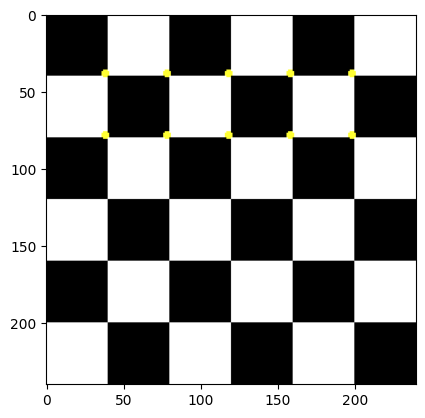

time taken to process the chessboard image is 8.546


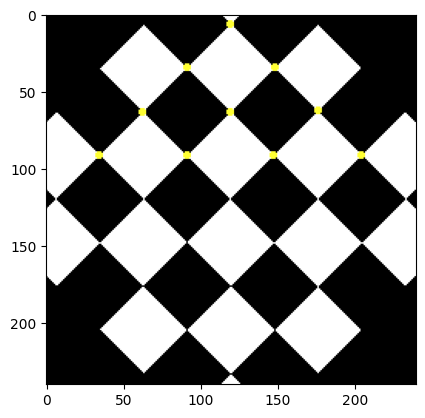

time taken to process the chessboard-rotated image is 9.853


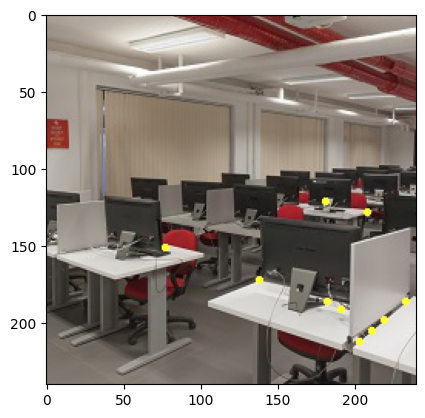

time taken to process the lab image is 7.842


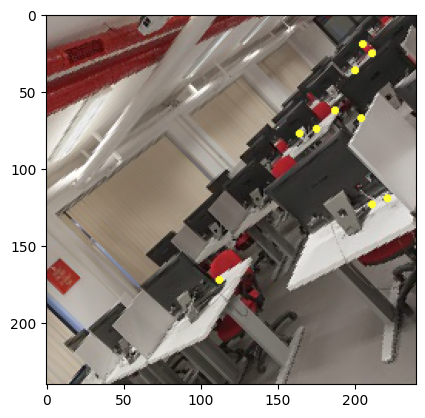

time taken to process the lab-rotated image is 6.949


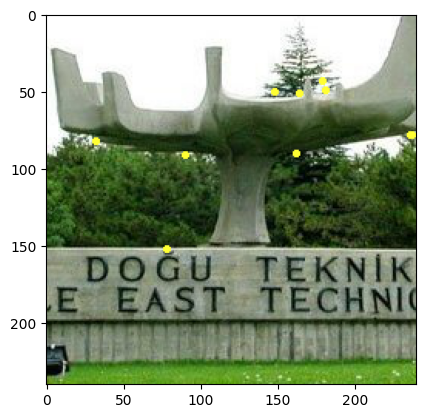

time taken to process the tree image is 7.583


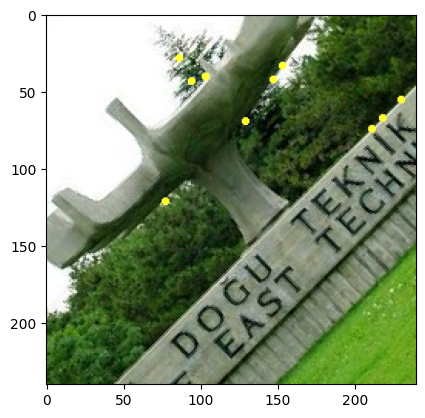

time taken to process the tree-rotated image is 7.449
the average time to process one image: 8.036868 


In [11]:
total_time = 0
for i in range(6):
    start = time.time()
    max_indices = taylors_approximation(images[i])
    end = time.time()
    display_max_circles(images[i], max_indices)
    time_passed= (end-start)
    total_time += time_passed
    print(f"time taken to process the {image_names[i]} image is {round(time_passed, 3)}")
print("the average time to process one image: %f " % (total_time/6))

In this version, the taylor approximation method is used to improve accuracy compared to the naive formula as it provides better localization of corners. Rotation invariance is not achieved, and the average time to process one image is high due to matrix multiplication over eight directions (more computationally expensive than the naive formula). Since we use non-maximum suppression, there are 10 distinct corners that are not overlapped.

## Fast Implementation + Uniform Weighting

In [12]:
def fast_uniform(image):

    #converting the image into gray scale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    
    dx = np.gradient(gray_image, axis=1)
    dy = np.gradient(gray_image, axis=0)

    Ixx = dx**2
    Iyy = dy**2
    Ixy = dx*dy

    # computing sums of products of gradients
    kernel = np.ones((3, 3))
    Ixx = convolve(Ixx, kernel)
    Iyy = convolve(Iyy, kernel)
    Ixy = convolve(Ixy, kernel)
   
    # computing the harris response
    harris_response = (Ixx * Iyy - Ixy**2) - 0.04 * ((Ixx + Iyy)**2)
    
    suppressed_distances = non_maximum_suppression(harris_response)

    #calculating the max 10 values
    max_indices = max_10_indices(suppressed_distances)

    return max_indices


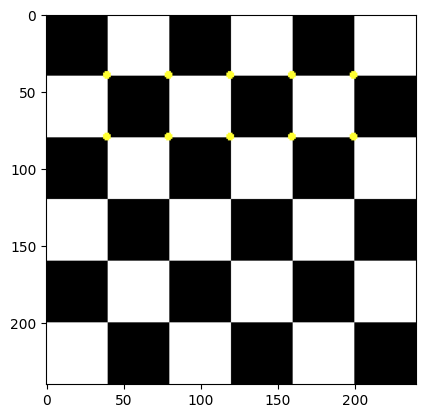

time taken to process the chessboard image is 0.813


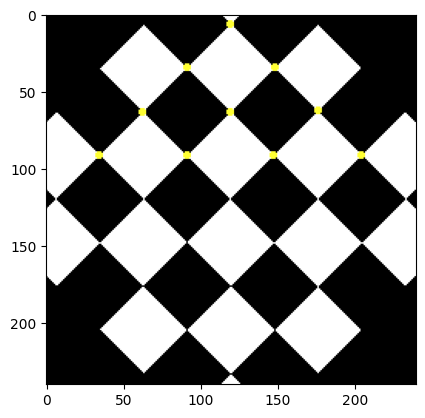

time taken to process the chessboard-rotated image is 1.012


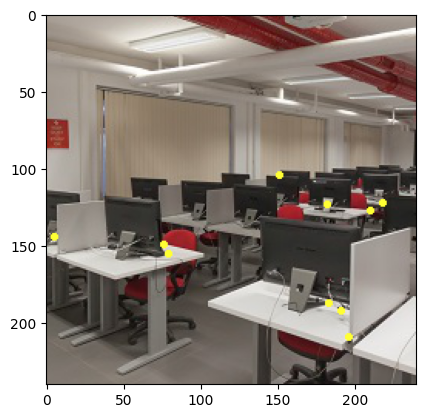

time taken to process the lab image is 0.618


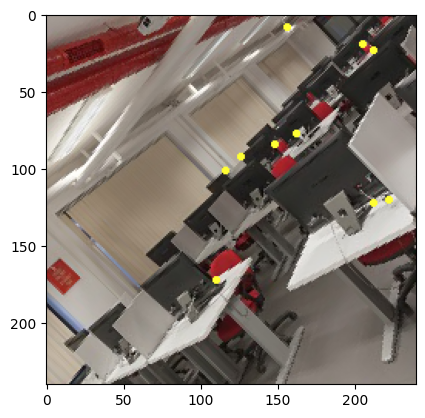

time taken to process the lab-rotated image is 0.683


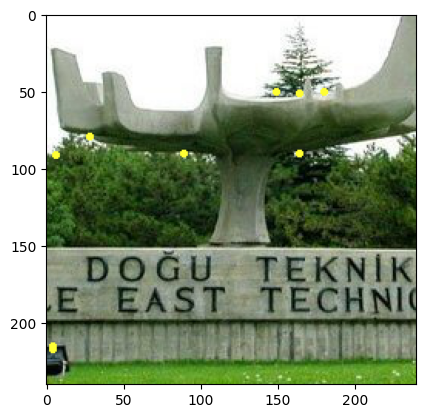

time taken to process the tree image is 0.787


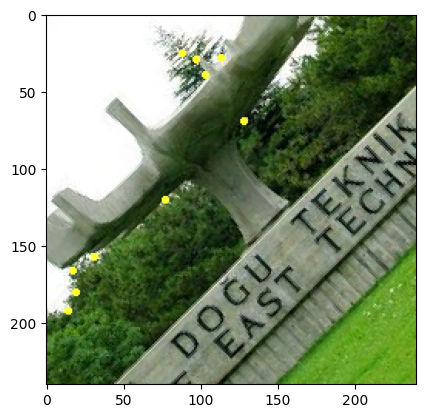

time taken to process the tree-rotated image is 0.794
the average time to process one image: 0.784474 


In [13]:
total_time = 0
for i in range(6):
    start = time.time()
    max_indices = fast_uniform(images[i])
    end = time.time()
    display_max_circles(images[i], max_indices)
    time_passed= (end-start)
    total_time += time_passed
    print(f"time taken to process the {image_names[i]} image is {round(time_passed, 3)}")
print("the average time to process one image: %f " % (total_time/6))

This version introduces a modification to the Harris corner detector by directly calculating the harris response from its trace and delta values. This method may sacrifice some accuracy for speed, but it is much faster than the previous version, as it avoids matrix multiplication over eight directions while maintaining better corner detection. It includes non-maximum suppression, ensuring distinct corners, and exhibits a degree of rotation invariance. Even though it is not inherently scale or rotationally invariant, detected corners are relatively closer in both rotated and original images.

## Fast Implementation + Circular Weighting

In [14]:
def fast_circular(image):

    # converting the image into gray scale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    
    dx = np.gradient(gray_image, axis=1)
    dy = np.gradient(gray_image, axis=0)

    Ixx = dx**2
    Iyy = dy**2
    Ixy = dx*dy

    # circular weighting
    kernel = np.zeros((3, 3))
    for x in range(-1, 2):
        for y in range(-1, 2):
            if x**2 + y**2 <= 1:
                kernel[x + 1, y + 1] = 1
    kernel /= np.sum(kernel)
    
    Ixx = convolve(Ixx, kernel)
    Iyy = convolve(Iyy, kernel)
    Ixy = convolve(Ixy, kernel)

    # computing the harris response
    harris_response = (Ixx * Iyy - Ixy**2) - 0.04 * ((Ixx + Iyy)**2)
    
    suppressed_distances = non_maximum_suppression(harris_response)

    #calculating the max 10 values
    max_indices = max_10_indices(suppressed_distances)

    return max_indices


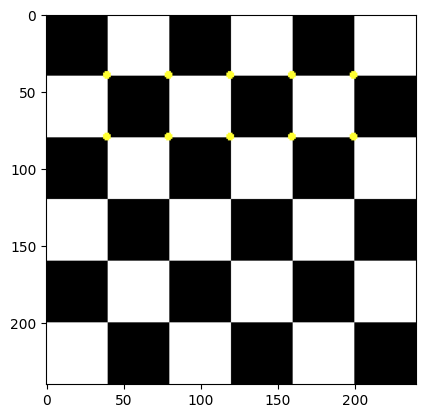

time taken to process the chessboard image is 0.758


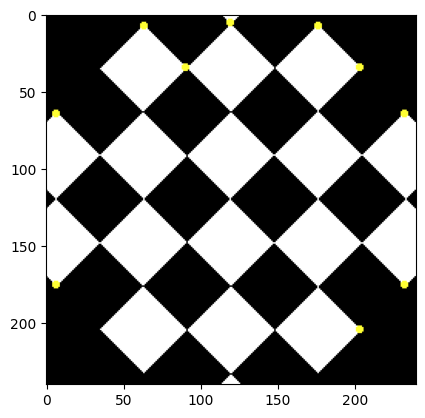

time taken to process the chessboard-rotated image is 0.912


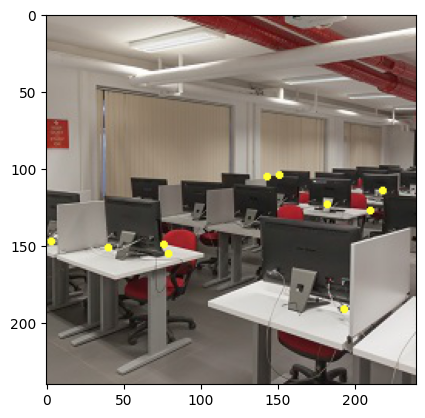

time taken to process the lab image is 0.643


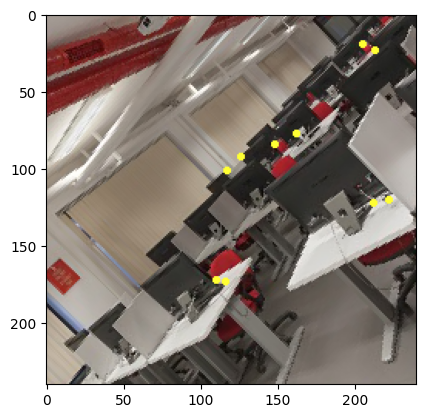

time taken to process the lab-rotated image is 0.649


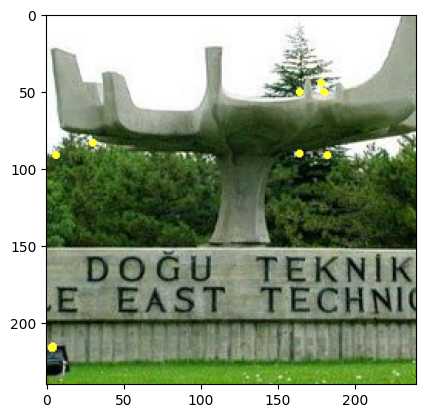

time taken to process the tree image is 0.677


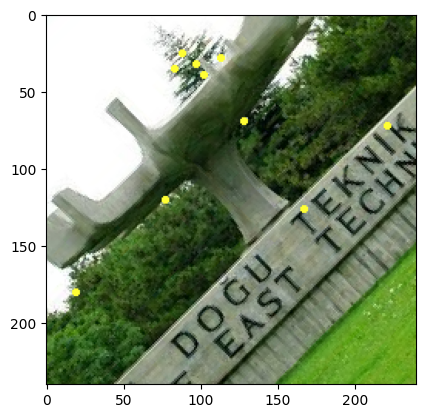

time taken to process the tree-rotated image is 0.971
the average time to process one image: 0.768386 


In [15]:
total_time = 0
for i in range(6):
    start = time.time()
    max_indices = fast_circular(images[i])
    end = time.time()
    display_max_circles(images[i], max_indices)
    time_passed= (end-start)
    total_time += time_passed
    print(f"time taken to process the {image_names[i]} image is {round(time_passed, 3)}")
print("the average time to process one image: %f " % (total_time/6))

Using circular weighting instead of uniform weighting improves accuracy, and reduces the sensitivity to noise. It can handle corners at different scales. However, this versions computational complexity is increased compared to uniform weighting. While it is more scale-invariant, it is still lack rotational invariance, detected corners are seems to be close in both rotated and original images.

## Fast Implementation + Gaussian Weighting

In [16]:
# Write your code here
def fast_gaussian(image):

    # converting the image into gray scale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    
    dx = np.gradient(gray_image, axis=1)
    dy = np.gradient(gray_image, axis=0)

    Ixx = dx**2
    Iyy = dy**2
    Ixy = dx*dy

    # applying gaussian filter
    Ixx = scipy.ndimage.gaussian_filter(Ixx, sigma=1)
    Iyy = scipy.ndimage.gaussian_filter(Iyy, sigma=1)
    Ixy = scipy.ndimage.gaussian_filter(Ixy, sigma=1)
    
    # computing the harris response
    harris_response = (Ixx * Iyy - Ixy**2) - 0.04 * ((Ixx + Iyy)**2)
    
    suppressed_distances = non_maximum_suppression(harris_response)

    #calculating the max 10 values
    max_indices = max_10_indices(suppressed_distances)

    return max_indices

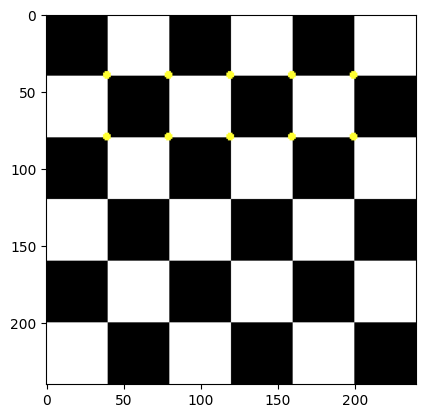

time taken to process the chessboard image is 0.766


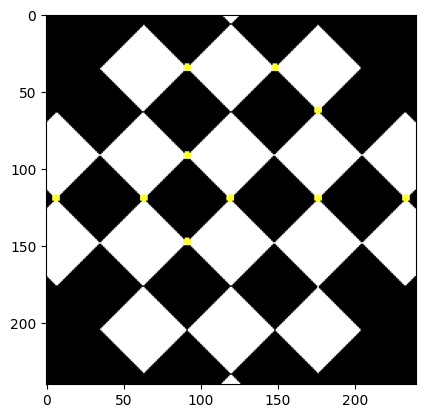

time taken to process the chessboard-rotated image is 0.804


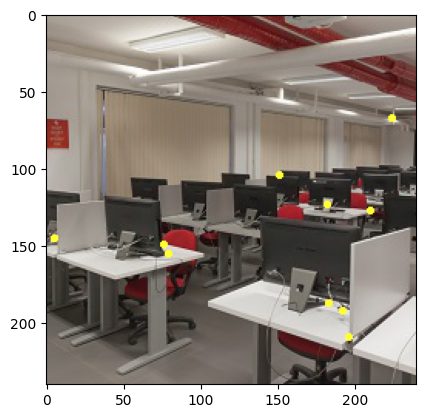

time taken to process the lab image is 0.729


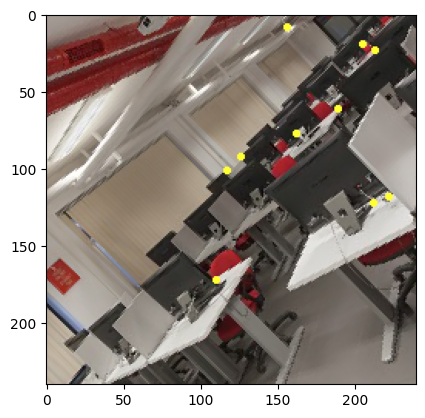

time taken to process the lab-rotated image is 0.636


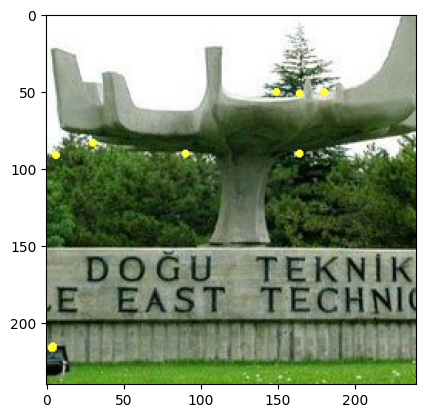

time taken to process the tree image is 0.672


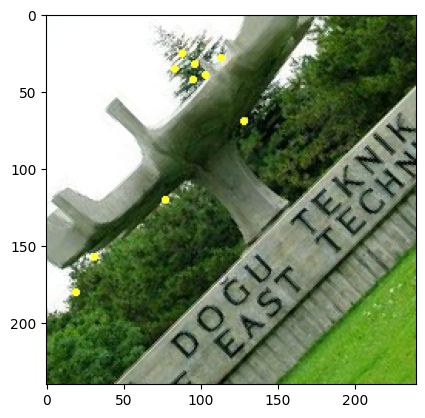

time taken to process the tree-rotated image is 0.803
the average time to process one image: 0.735144 


In [17]:
total_time = 0
for i in range(6):
    start = time.time()
    max_indices = fast_gaussian(images[i])
    end = time.time()
    display_max_circles(images[i], max_indices)
    time_passed= (end-start)
    total_time += time_passed
    print(f"time taken to process the {image_names[i]} image is {round(time_passed, 3)}")
print("the average time to process one image: %f " % (total_time/6))

Using gaussian weighting improves the noise robustness, making it more suitable for real-world images. However, It has higher computational complexity compared to uniform weighting. It is not fully scale or rotationally invariant, but detected corners are relatively closer in both rotated and original images.

## Fast Implementation + Gaussian Weighting + RGB Split

In [18]:
def fast_gaussian_rgb(image):
    
    # splitting the image into RGB channels
    b, g, r = cv2.split(image)

    # initializing the combined Harris response
    final_response = None

    for channel in [b, g, r]:
        
        dx = np.gradient(channel, axis=1)
        dy = np.gradient(channel, axis=0)

        Ixx = dx**2
        Iyy = dy**2
        Ixy = dx*dy

        # appying gaussian filter
        Ixx = scipy.ndimage.gaussian_filter(Ixx, sigma=1)
        Iyy = scipy.ndimage.gaussian_filter(Iyy, sigma=1)
        Ixy = scipy.ndimage.gaussian_filter(Ixy, sigma=1)

        # computing the harris response
        harris_response = (Ixx * Iyy - Ixy**2) - 0.04 * ((Ixx + Iyy)**2)

        if final_response is None:
            final_response = harris_response
        else:
            final_response += harris_response

    suppressed_distances = non_maximum_suppression(final_response)

    #calculating the max 10 values
    max_indices = max_10_indices(suppressed_distances)

    return max_indices

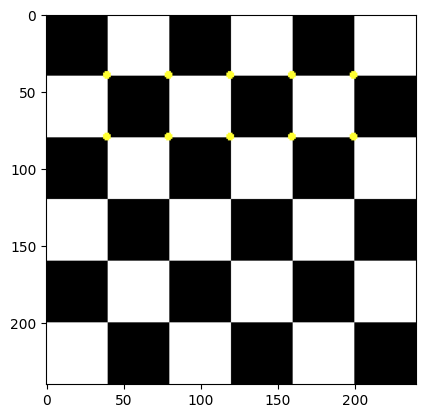

time taken to process the chessboard image is 0.746


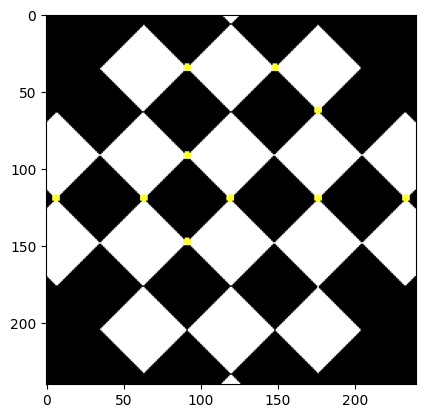

time taken to process the chessboard-rotated image is 0.696


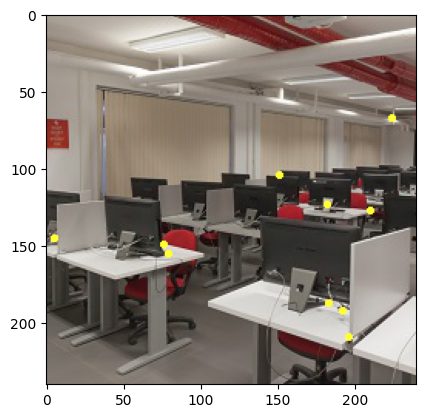

time taken to process the lab image is 0.688


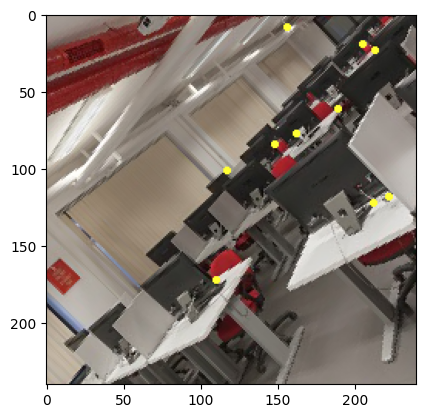

time taken to process the lab-rotated image is 0.978


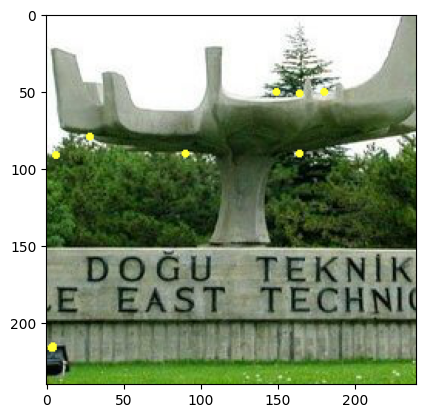

time taken to process the tree image is 0.688


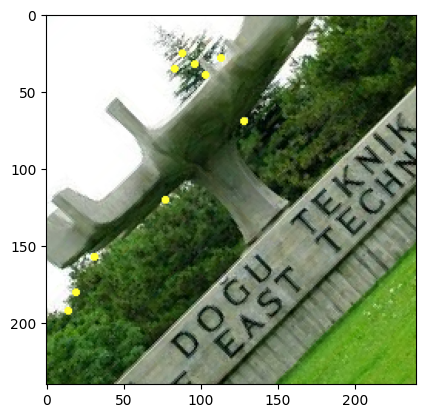

time taken to process the tree-rotated image is 0.669
the average time to process one image: 0.744135 


In [19]:
total_time = 0
for i in range(6):
    start = time.time()
    max_indices = fast_gaussian_rgb(images[i])
    end = time.time()
    display_max_circles(images[i], max_indices)
    time_passed= (end-start)
    total_time += time_passed
    print(f"time taken to process the {image_names[i]} image is {round(time_passed, 3)}")
print("the average time to process one image: %f " % (total_time/6))

This version takes into account color information by splitting channels, potentially improving performance for color images. However, it we consider our input images, there seems to be no significant improvement. Since it separates channels it has higher complexity. Like the other versions, it is not entirely scale or rotationally invariant, but detected corners are relatively closer in both rotated and original images too.

# Conclusion

In general, the choice of a specific version depends on the application requirements, computational resources, and the desired balance between accuracy and speed. Naive formulations are simple but may lack robustness, while more advanced versions offer improved accuracy at the cost of increased complexity. In terms of scale invariance, circular and gaussian weighting contribute to improving performance at different scales, but none of the variants provide complete scale invariance. Since these versions are based on local intensity gradients, they are more likely to be sensitive to rotation. Among these versions fast implementation with gaussian weigthing seems to be a better choice (there may be no need to rgb split as it increases the complexity), but depending on the applicaiton using rgb split can be preferred. 